In [18]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import scipy.io
from scipy.interpolate import griddata
import numpy as np
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 

In [3]:
from os.path import dirname, join as pjoin

import scipy.io as sio 

In [8]:
data_dir = pjoin(dirname(sio.__file__), 'matlab', 'test', 'data')

mat_fname = pjoin(data_dir, 'testdouble_7.4_GLNX86.mat')

In [15]:
#mat_contents = sio.loadmat(mat_fname)

2. Collecting the Data.

We use the variables x and t as corresponding to the equations mentioned above. The dimensions of x and t are (256, 1) and (100,1) respectively. We then make a grid using np.meshgrid which outputs dimensions of (100, 256). This is done to correspond to the dimensions of usol which is (100, 256).

In [20]:
data = scipy.io.loadmat(r'C:\Users\chidi\Downloads\burgers_shock.mat')
x = data['x'].flatten()[:, None]
t = data['t'].flatten()[:, None]
usol = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
train = torch.concat([torch.Tensor(X.flatten()[:, None]), torch.Tensor(T.flatten()[:, None])], 1)
X_min = train.min(0)
X_max = train.max(0)

3. Make a Neural Network.

This is what was discussed in the above section. We paramterize u(x, t) using a Neural Network. Feel free to change the hyperparameters given below.

In [21]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16,32)
        self.fc3 = nn.Linear(32,1)
    
    def forward(self,x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

4. Make the Physics Informed Neural Network Class.



In [22]:
#Making the Physics Informed NN here, look at `physics` to adjust between PINN and Vanilla NN.
class PINN():
    def __init__(self, X, u, lb, ub, physics):
        
        self.lb = torch.tensor(lb).float()
        self.ub = torch.tensor(ub).float()
        self.physics = physics
        
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float()
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float()
        self.u = torch.tensor(u).float()
        
        self.network = Network()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=0.001)
        
    def makeNetwork(self, x,t):
        X = torch.cat([x,t],1)
        return self.network(X)
    
    def residual(self, x, t):
        
        u = self.makeNetwork(x, t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),  create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u) , create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u_x) ,create_graph=True)[0]
        
        return u_t + u*u_x - (0.01/np.pi)*u_xx
    
    def train(self, epochs):
        lossTracker = []
        self.network.train()
        for idx in range(epochs):
            u_pred = self.makeNetwork(self.x, self.t)
            residual_pred = self.residual(self.x, self.t)
            loss = torch.mean((self.u - u_pred)**2)
            if self.physics == True:
                loss += torch.mean(residual_pred**2)
            #print(f"The loss at epoch {idx} is {loss.item()}")
            lossTracker.append(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return lossTracker
            
    def predict(self): 
        self.network.eval()
        u = self.makeNetwork(self.x, self.t)
        res = self.residual(self.x, self.t)
        return u.detach().numpy(), res.detach().numpy()

__ init __() : The function here initializes the neural network, the optimizer and other variables in use.

makeNetwork() : The variables are concatenated as depicted in the first layer of the network, and passed through the network, returning the output of the operations.

residual() : As mentioned above as well, the residual term acts as a “regularizer” in the loss. The u_t, u_x and u_xx terms are derived by using the torch.autograd.grad feature, which computes the differential of the terms with respect to the mentioned inputs and outputs. This is the “automatic differentiation” property that is exploited using such methods.

train() : This is used to train the network. Note the use of the physics parameter, that controls whether the implementation is that of a PINN or a Vanilla Neural Network. Also consider the loss term, containing both losses as discussed above in the form of u_pred and residual_pred terms. We perform the backpropogation step at last.

predict() : This is used for evaluating the network.

In [23]:
idx = np.random.choice(train.shape[0], 2000, replace=False)
X_u_train = train[idx, :]
u_train = usol.flatten()[:, None][idx,:]
model = PINN(X_u_train, u_train, X_min[0], X_max[0], True) # Keep False for Vanilla
pinn = model.train(1000)

C:\Users\chidi\AppData\Local\Temp\ipykernel_58056\1282948283.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.lb = torch.tensor(lb).float()
C:\Users\chidi\AppData\Local\Temp\ipykernel_58056\1282948283.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ub = torch.tensor(ub).float()
C:\Users\chidi\AppData\Local\Temp\ipykernel_58056\1282948283.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(X[:, 0:1], requires_grad=True).float()
C:\Users\chidi\AppData\Local\Temp\ipykernel_58056\1282948283.py:10: UserWa

In [24]:
pinn

[0.4121968150138855,
 0.40854617953300476,
 0.40503692626953125,
 0.4016307294368744,
 0.3983193337917328,
 0.39511027932167053,
 0.3920079469680786,
 0.3890047073364258,
 0.3860902488231659,
 0.3832795321941376,
 0.38049089908599854,
 0.37776637077331543,
 0.37508606910705566,
 0.3724488317966461,
 0.3698430359363556,
 0.3672809898853302,
 0.3647270202636719,
 0.36216965317726135,
 0.3596149682998657,
 0.35708045959472656,
 0.3545898199081421,
 0.35215094685554504,
 0.3497806489467621,
 0.34747034311294556,
 0.3452202379703522,
 0.3430282771587372,
 0.3408831059932709,
 0.3387954533100128,
 0.3367559313774109,
 0.33473432064056396,
 0.33274397253990173,
 0.33080437779426575,
 0.32887741923332214,
 0.3269730508327484,
 0.3250878155231476,
 0.3232082426548004,
 0.3213450014591217,
 0.31950119137763977,
 0.31765317916870117,
 0.3158324658870697,
 0.31401675939559937,
 0.3122164011001587,
 0.3103952705860138,
 0.30860430002212524,
 0.3068239390850067,
 0.3050534725189209,
 0.3032934367656

# Making a Multilayer Perceptron  **MLP**

A **Multilayer Perceptron (MLP)** is a type of artificial neural network composed of multiple layers of nodes, where each layer is connected to the subsequent one. MLPs are widely used for solving classification, regression, and time-series prediction tasks, making them a versatile tool in machine learning.

### Structure of an MLP
1. **Input Layer**: Receives input features; the number of neurons here equals the number of input features.
2. **Hidden Layers**: Composed of one or more hidden layers between the input and output layers, where most of the learning happens. Each neuron in a hidden layer applies an activation function, often a non-linear function like ReLU, Sigmoid, or Tanh, to introduce complexity and enable learning of non-linear relationships.
3. **Output Layer**: Outputs the final prediction. In a classification problem, this layer usually has softmax activation for multiclass classification or sigmoid activation for binary classification. In regression, no activation or a linear activation function is commonly used.

### Key Concepts in MLP
- **Forward Propagation**: Data is fed forward through the layers from input to output. Each neuron's output is calculated by a weighted sum of its inputs followed by the activation function.
- **Backpropagation**: An algorithm used to train the MLP by adjusting weights. It computes the gradient of the loss function with respect to each weight by moving from the output layer back through each layer, which is crucial for optimizing the network.
- **Optimization Algorithms**: The weights are updated by optimization algorithms, with Stochastic Gradient Descent (SGD) and Adam being popular choices.

### Advantages
- **Universal Approximation**: MLPs can approximate any continuous function with sufficient neurons and layers, making them powerful for a range of applications.
- **Feature Learning**: They automatically learn feature representations, which reduces the need for manual feature engineering.

### Disadvantages
- **Training Time**: MLPs can be slow to train, especially with large networks and data.
- **Overfitting**: They are prone to overfitting, particularly with small datasets, due to their high capacity to memorize patterns.

### Practical Use
MLPs are commonly used in problems where data is structured and relatively low-dimensional, such as in tabular data, though they are often outperformed by specialized architectures in high-dimensional data tasks, like Convolutional Neural Networks (CNNs) in image processing or Recurrent Neural Networks (RNNs) in sequential data.

In your context, working in public health, an MLP could be useful for predicting disease spread or patient outcomes based on various health indicators, given its ability to handle complex relationships in data.

We will define and train the following MLP:

$$
N\!N(\mathbf{x})= W_3(\sigma\,(W_2(\sigma\,(W_1 \mathbf{x} + \mathbf{b_1}) + \mathbf{b_2}) + \mathbf{b_3} = f \circ \mathbf{g} \circ \mathbf{h}\,(x) \\
\mathbf{h} = W_1 \mathbf{x} + \mathbf{b_1} \\
\mathbf{g} = W_2 \sigma\,(\mathbf{h}) + \mathbf{b_2} \\
f = W_3 \sigma\,(\mathbf{g}) + \mathbf{b_3} \\
$$

For which its gradients are given by :

$$
\begin{align}
\frac{\partial L}{\partial W_1} &= \frac{\partial L}{\partial f} \frac{\partial f}{\partial \mathbf{g}} \frac{\partial \mathbf{g}}{\partial \mathbf{h}} \frac{\partial \mathbf{h}}{\partial W_1} \\
&= \frac{1}{N}\sum^{N}_{i} 2(f_i - y(\mathbf{x}_i)) \, W_3 \mathrm{diag}(\sigma'(\mathbf{g_i})) \, W_2 \mathrm{diag}(\sigma'(\mathbf{h_i})) \, \otimes \mathbf{x}_i
\end{align}
$$

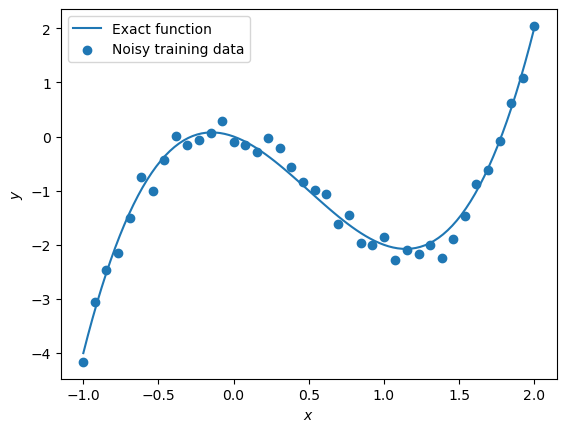

In [23]:
# Define some training data
lim = [-1,2]
x = np.linspace(*lim,40).reshape((-1,1,1))
x_true = np.linspace(*lim,100).reshape((-1,1,1))
y_fn = lambda theta, x: theta[3]*x**3 + theta[2]*x**2 + theta[1]*x + theta[0]
theta = [0,-1,-3,2]
y_true = y_fn(theta, x_true)
np.random.seed(123)
y = y_fn(theta, x) + np.random.normal(0,0.15,x.shape)

# Plot the training data
plt.figure()
plt.plot(x_true[:,0,0], y_true[:,0,0], label="Exact function")
plt.scatter(x[:,0,0], y[:,0,0], label="Noisy training data")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

(40, 8, 1) (40, 16, 1) (40, 1, 1)
(40, 1, 8) (40, 1, 16) (40, 1, 1)
(1, 8, 1) (1, 16, 8) (1, 1, 16)
(1, 8, 1) (1, 16, 1) (1, 1, 1)


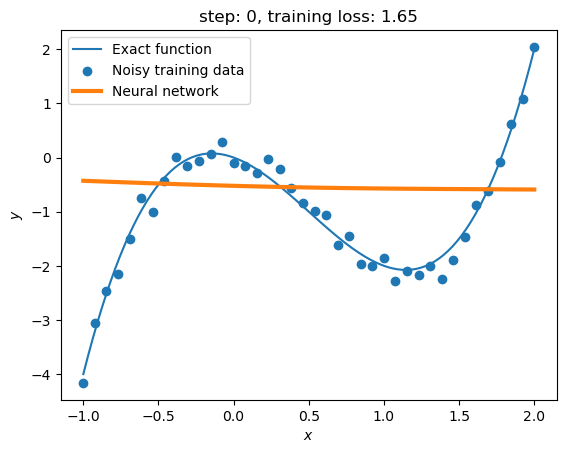

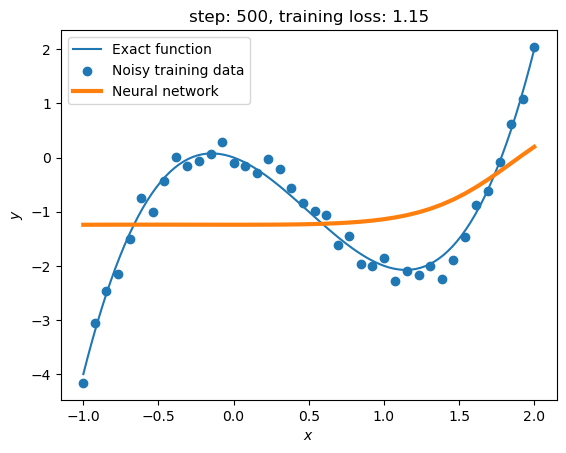

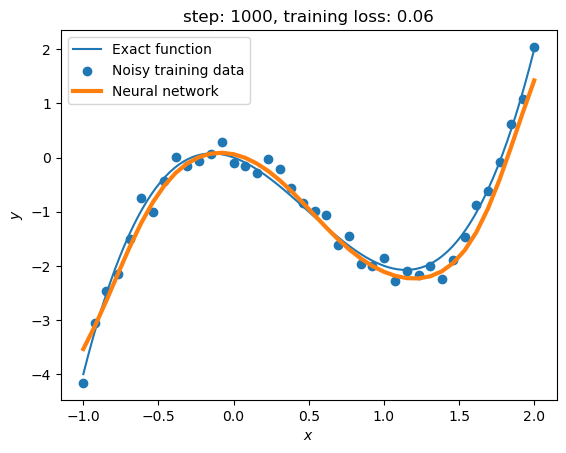

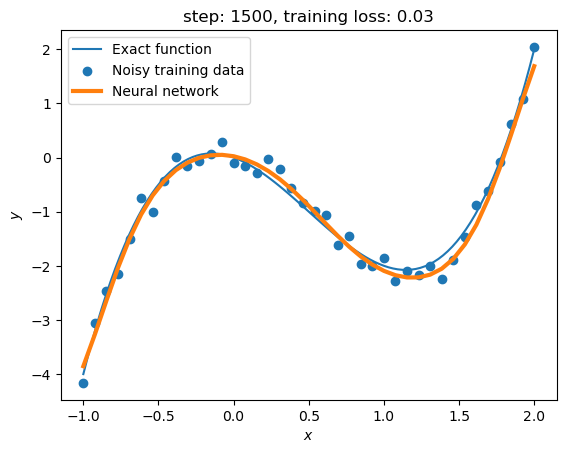

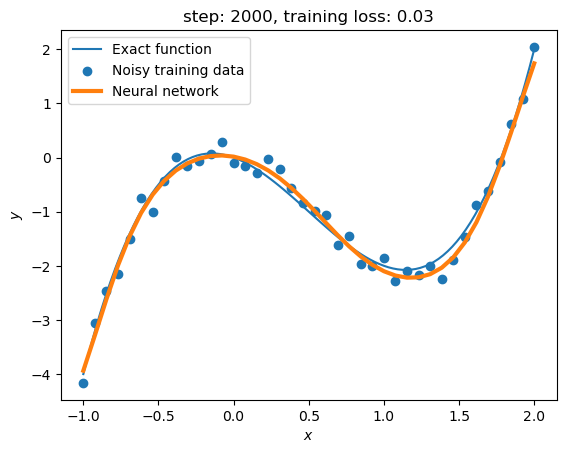

In [19]:
# define activation function
s = lambda x: np.tanh(x)
ds = lambda x: 1-np.tanh(x)**2# derivative of tanh

# Initialise weights
np.random.seed(0)
W1 = np.random.uniform(-1,1, (1, 8, 1))
W2 = np.random.uniform(-1,1, (1, 16, 8)) * np.sqrt(1/8)
W3 = np.random.uniform(-1,1, (1, 1, 16)) * np.sqrt(1/16)

b1 = np.random.uniform(-1,1, (1, 8, 1))
b2 = np.random.uniform(-1,1, (1, 16, 1)) * np.sqrt(1/8)
b3 = np.random.uniform(-1,1, (1, 1, 1)) * np.sqrt(1/16)

for i in range(2001):

    # forward pass
    h = W1 @ x + b1 # h: (N_examples, 8, 1)
    g = W2 @ s(h) + b2 # g: (N_examples, 16, 1)
    f = W3 @ s(g) + b3 # f: (N_examples, 1, 1)

    # reverse-mode backpropagation
    dldf = 2 * (f - y)# dl/df: (N_examples, 1, 1)
    dldg = (dldf @ W3) @ (ds(g)*np.expand_dims(np.eye(16),0))# dl/dg: (N_examples, 1, 16)
    dldh = (dldg @ W2) @ (ds(h)*np.expand_dims(np.eye(8),0))# dl/dh: (N_examples, 1, 8)

    dW1 = (dldh * x).transpose(0,2,1)# dl/dW1: (N_examples, 8, 1)
    dW2 = (dldg * s(h)).transpose(0,2,1)# dl/dW2: (N_examples, 16, 8)
    dW3 = (dldf * s(g)).transpose(0,2,1)# dl/dW3: (N_examples, 1, 16)
    
    db1 = dldh.transpose(0,2,1)# dl/db1: (N_examples, 8, 1)
    db2 = dldg.transpose(0,2,1)# dl/db2: (N_examples, 16, 1)
    db3 = dldf.transpose(0,2,1)# dl/db3: (N_examples, 1, 1)

    # get mean gradient across training examples
    dW1 = np.mean(dW1, 0, keepdims=True)
    dW2 = np.mean(dW2, 0, keepdims=True)
    dW3 = np.mean(dW3, 0, keepdims=True)
    db1 = np.mean(db1, 0, keepdims=True)
    db2 = np.mean(db2, 0, keepdims=True)
    db3 = np.mean(db3, 0, keepdims=True)
    
    # gradient descent step
    a = 0.05# learning rate
    W1 -= a * dW1
    W2 -= a * dW2
    W3 -= a * dW3
    b1 -= a * db1
    b2 -= a * db2
    b3 -= a * db3
    
    if i == 0: 
        print(h.shape, g.shape, f.shape)
        print(dldh.shape, dldg.shape, dldf.shape)
        print(dW1.shape, dW2.shape, dW3.shape)
        print(db1.shape, db2.shape, db3.shape)
        
    if i % 500 == 0: 
        
        # get loss value
        l = np.mean((f-y)**2)
        
        # Plot the training data
        plt.figure()
        plt.title(f"step: {i}, training loss: {l:.2f}")
        plt.plot(x_true[:,0,0], y_true[:,0,0], label="Exact function")
        plt.scatter(x[:,0,0], y[:,0,0], label="Noisy training data")
        plt.plot(x[:,0,0], f[:,0,0], lw=3, label="Neural network")
        plt.xlabel("$x$")
        plt.ylabel("$y$")
        plt.legend()
        plt.show()

This code defines a basic Multilayer Perceptron (MLP) with two hidden layers and an output layer. The network learns using backpropagation and gradient descent. Here’s a breakdown of the code and an explanation of how to expand it to include additional layers.

### Code Breakdown

1. **Activation Function**:
   - `s = lambda x: np.tanh(x)` defines the activation function as the hyperbolic tangent (`tanh`), which is commonly used in neural networks for hidden layers due to its non-linearity.
   - `ds = lambda x: 1 - np.tanh(x)**2` is the derivative of `tanh`, necessary for calculating gradients during backpropagation.

2. **Weight and Bias Initialization**:
   - The weights `W1`, `W2`, and `W3` are initialized for each layer. The shapes represent the number of neurons in each layer:
     - `W1` has a shape of `(1, 8, 1)`, meaning it connects a single input node to 8 nodes in the first hidden layer.
     - `W2` has a shape of `(1, 16, 8)`, meaning it connects 8 nodes in the first hidden layer to 16 nodes in the second hidden layer.
     - `W3` has a shape of `(1, 1, 16)`, meaning it connects 16 nodes in the second hidden layer to a single output node.
   - The biases `b1`, `b2`, and `b3` are initialized similarly to correspond to each layer.
   - Weights are scaled using `np.sqrt(1 / n_neurons)`, which helps with convergence.

3. **Forward Pass**:
   - The forward pass computes the activations layer by layer:
     - `h = W1 @ x + b1`: The first hidden layer output.
     - `g = W2 @ s(h) + b2`: The second hidden layer output after applying `tanh`.
     - `f = W3 @ s(g) + b3`: The final output after applying `tanh`.

4. **Backpropagation**:
   - The code calculates the gradients of the loss with respect to each weight and bias. This involves:
     - Calculating `dldf`, `dldg`, and `dldh`, the gradients of the loss with respect to `f`, `g`, and `h`, respectively.
     - Calculating the gradients with respect to each weight (`dW1`, `dW2`, `dW3`) and bias (`db1`, `db2`, `db3`).
     - Taking the mean of these gradients across training examples for batch gradient descent.

5. **Parameter Update**:
   - The weights and biases are updated with a gradient descent step, using a learning rate `a = 0.05`.

6. **Training Loop and Visualization**:
   - The network trains for 2001 steps, printing and plotting the training progress every 500 steps.

### How to Add More Layers
To add more layers to the MLP, you would need to:
1. **Define Additional Weights and Biases**:
   - Initialize new weight matrices and bias vectors for each additional layer. For example, if you want to add a third hidden layer with 32 neurons:
     ```python
     W4 = np.random.uniform(-1, 1, (1, 32, 16)) * np.sqrt(1 / 16)
     b4 = np.random.uniform(-1, 1, (1, 32, 1)) * np.sqrt(1 / 16)
     ```
   - Update the existing output layer’s weights to match the new layer’s dimensions:
     ```python
     W5 = np.random.uniform(-1, 1, (1, 1, 32)) * np.sqrt(1 / 32)
     b5 = np.random.uniform(-1, 1, (1, 1, 1)) * np.sqrt(1 / 32)
     ```

2. **Extend the Forward Pass**:
   - Insert the new layer(s) into the forward pass:
     ```python
     g2 = W3 @ s(g) + b3  # Output of third hidden layer
     f = W4 @ s(g2) + b4  # Final output layer
     ```

3. **Adjust Backpropagation**:
   - Calculate gradients for the additional layers.

To adjust backpropagation for an additional layer, you need to calculate the gradients with respect to the new layer’s weights, biases, and outputs. When you add a new layer in an MLP, backpropagation requires you to compute derivatives for that layer and "chain" them through each preceding layer. Here’s a step-by-step guide on how to incorporate a new hidden layer into the backpropagation process.

### Adding an Extra Hidden Layer to Backpropagation

Let’s assume you’ve added a third hidden layer with weights `W4` and biases `b4`, with 32 neurons. This new layer’s output would be denoted as `g2`, and the final layer weights and biases are `W5` and `b5`. 

### 1. Initialize Additional Parameters for the New Layer
First, you’ll need to initialize weights and biases for the new hidden layer and the updated output layer, as we discussed:

```python
W4 = np.random.uniform(-1, 1, (1, 32, 16)) * np.sqrt(1 / 16)
b4 = np.random.uniform(-1, 1, (1, 32, 1)) * np.sqrt(1 / 16)

W5 = np.random.uniform(-1, 1, (1, 1, 32)) * np.sqrt(1 / 32)
b5 = np.random.uniform(-1, 1, (1, 1, 1)) * np.sqrt(1 / 32)
```

### 2. Extend the Forward Pass
You’ll add the new layer’s calculation in the forward pass:

```python
h = W1 @ x + b1               # First hidden layer
g = W2 @ s(h) + b2            # Second hidden layer
g2 = W3 @ s(g) + b3           # New third hidden layer
f = W5 @ s(g2) + b5           # Final output layer
```

### 3. Modify the Backpropagation
Now, you’ll need to adjust the backpropagation calculations to include `W4` and `b4`. Here’s how:

1. **Compute the Loss Gradient for the Output Layer**:
   ```python
   dldf = 2 * (f - y)  # Gradient of loss w.r.t final output
   ```

2. **Backpropagate from Output to Third Hidden Layer**:
   ```python
   dldg2 = (dldf @ W5) * ds(g2)  # Gradient w.r.t. third hidden layer
   dW5 = (dldf * s(g2)).transpose(0, 2, 1)  # Gradient w.r.t. W5
   db5 = dldf.transpose(0, 2, 1)            # Gradient w.r.t. b5
   ```

3. **Backpropagate from Third Hidden Layer to Second Hidden Layer**:
   ```python
   dldg = (dldg2 @ W4) * ds(g)  # Gradient w.r.t. second hidden layer
   dW4 = (dldg2 * s(g)).transpose(0, 2, 1)  # Gradient w.r.t. W4
   db4 = dldg2.transpose(0, 2, 1)           # Gradient w.r.t. b4
   ```

4. **Backpropagate from Second Hidden Layer to First Hidden Layer**:
   ```python
   dldh = (dldg @ W3) * ds(h)  # Gradient w.r.t. first hidden layer
   dW3 = (dldg * s(h)).transpose(0, 2, 1)   # Gradient w.r.t. W3
   db3 = dldg.transpose(0, 2, 1)            # Gradient w.r.t. b3
   ```

5. **Calculate Gradients for the First Hidden Layer**:
   ```python
   dW1 = (dldh * x).transpose(0, 2, 1)  # Gradient w.r.t. W1
   db1 = dldh.transpose(0, 2, 1)        # Gradient w.r.t. b1
   ```

### 4. Update the Parameters
Finally, update all weights and biases using gradient descent:

```python
a = 0.05  # Learning rate
W1 -= a * np.mean(dW1, 0, keepdims=True)
W2 -= a * np.mean(dW2, 0, keepdims=True)
W3 -= a * np.mean(dW3, 0, keepdims=True)
W4 -= a * np.mean(dW4, 0, keepdims=True)
W5 -= a * np.mean(dW5, 0, keepdims=True)

b1 -= a * np.mean(db1, 0, keepdims=True)
b2 -= a * np.mean(db2, 0, keepdims=True)
b3 -= a * np.mean(db3, 0, keepdims=True)
b4 -= a * np.mean(db4, 0, keepdims=True)
b5 -= a * np.mean(db5, 0, keepdims=True)
```

With these modifications, you’ve added an extra hidden layer to both the forward and backward passes of the MLP. This approach can be extended further by adding more layers, repeating similar steps for each additional layer.

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def mlp_train2(x, y, num_layers=3, num_neurons=[8, 16, 32], learning_rate=0.05, epochs=2001):
    # Activation function and its derivative
    s = lambda x: np.tanh(x)
    ds = lambda x: 1 - np.tanh(x) ** 2  # derivative of tanh

    # Initialize weights and biases for each layer
    weights = []
    biases = []
    
    np.random.seed(0)  # For reproducibility
    
    # Set input dimension from x
    input_dim = x.shape[1]
    
    # Initialize weights and biases for hidden layers
    for i in range(num_layers):
        output_dim = num_neurons[i]
        weight = np.random.uniform(-1, 1, (output_dim, input_dim)) * np.sqrt(1 / input_dim)
        bias = np.random.uniform(-1, 1, (output_dim, 1)) * np.sqrt(1 / input_dim)
        
        weights.append(weight)
        biases.append(bias)
        
        input_dim = output_dim

    # Output layer
    weights.append(np.random.uniform(-1, 1, (1, input_dim)) * np.sqrt(1 / input_dim))
    biases.append(np.random.uniform(-1, 1, (1, 1)) * np.sqrt(1 / input_dim))

    # Training loop
    for epoch in range(epochs):
        # Forward pass
        activations = [x.T]  # Transpose x to shape (features, samples)
        for i in range(num_layers):
            z = weights[i] @ activations[-1] + biases[i]
            activations.append(s(z))
        
        # Output layer
        f = weights[-1] @ activations[-1] + biases[-1]
        
        # Loss
        loss = np.mean((f - y.T) ** 2)  # y should also be transposed to match f's shape

        # Backpropagation
        dldf = 2 * (f - y.T) / x.shape[0]  # Divide by number of samples for mean gradient
        gradients = [dldf]

        # Backprop through layers
        for i in range(num_layers, 0, -1):
            dldg = (weights[i].T @ gradients[0]) * ds(activations[i])
            gradients.insert(0, dldg)
        
        # Calculate gradients for weights and biases
        weight_grads = []
        bias_grads = []
        
        for i in range(num_layers):
            # Ensure correct shapes for matrix multiplication
            dW = gradients[i + 1] @ activations[i].T
            db = np.sum(gradients[i + 1], axis=1, keepdims=True)
            weight_grads.append(dW)
            bias_grads.append(db)

        # Output layer gradients
        dW_output = gradients[-1] @ activations[-1].T
        db_output = np.sum(gradients[-1], axis=1, keepdims=True)
        weight_grads.append(dW_output)
        bias_grads.append(db_output)

        # Update weights and biases
        for i in range(num_layers):
            weights[i] -= learning_rate * weight_grads[i]
            biases[i] -= learning_rate * bias_grads[i]

        weights[-1] -= learning_rate * weight_grads[-1]
        biases[-1] -= learning_rate * bias_grads[-1]

        # Plot and print loss every 500 steps
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
            plt.figure()
            plt.title(f"Epoch {epoch}, Loss: {loss:.4f}")
            plt.plot(x[:, 0], y[:, 0], label="Exact function")
            plt.scatter(x[:, 0], y[:, 0], label="Training data")
            plt.plot(x[:, 0], f.T[:, 0], lw=3, label="MLP Prediction")
            plt.xlabel("$x$")
            plt.ylabel("$y$")
            plt.legend()
            plt.show()
    
    return weights, biases


In [32]:
import numpy as np
import matplotlib.pyplot as plt

def mlp_train(x, y, num_layers=3, num_neurons=None, learning_rate=0.05, epochs=2001):
    # Activation function and its derivative
    s = lambda x: np.tanh(x)
    ds = lambda x: 1 - np.tanh(x) ** 2  # Derivative of tanh
    
    # Default number of neurons if not provided
    if num_neurons is None:
        num_neurons = [8] * num_layers  # Example: If no neurons are provided, use 8 neurons in each layer

    # Initialize weights and biases for each layer
    weights = []
    biases = []
    
    np.random.seed(0)  # For reproducibility
    
    # Set input dimension from x
    input_dim = x.shape[1]

    # Initialize weights and biases for hidden layers
    for i in range(num_layers):
        output_dim = num_neurons[i]
        weight = np.random.uniform(-1, 1, (input_dim, output_dim)) * np.sqrt(1 / input_dim)
        bias = np.random.uniform(-1, 1, (1, output_dim)) * np.sqrt(1 / input_dim)
        
        weights.append(weight)
        biases.append(bias)
        
        input_dim = output_dim  # Set input_dim for the next layer

    # Output layer
    weights.append(np.random.uniform(-1, 1, (input_dim, 1)) * np.sqrt(1 / input_dim))
    biases.append(np.random.uniform(-1, 1, (1, 1)) * np.sqrt(1 / input_dim))

    # Training loop
    for i in range(epochs):
        # Forward pass
        activations = [x]  # Store the input as the first activation
        for j in range(num_layers):
            z = activations[-1] @ weights[j] + biases[j]  # z = xW + b
            activations.append(s(z))  # Apply activation function

        # Output layer
        f = activations[-1] @ weights[-1] + biases[-1]
        
        # Loss calculation
        loss = np.mean((f - y) ** 2)

        # Backpropagation
        dldf = 2 * (f - y) / x.shape[0]  # Derivative of the loss w.r.t output
        gradients = [dldf]

        # Backprop through layers
        for j in range(num_layers, 0, -1):
            dldg = (gradients[0] @ weights[j].T) * ds(activations[j])
            gradients.insert(0, dldg)

        # Calculate gradients for weights and biases
        weight_grads = []
        bias_grads = []

        for j in range(num_layers):
            dW = activations[j].T @ gradients[j + 1]
            db = np.sum(gradients[j + 1], axis=0, keepdims=True)
            weight_grads.append(dW)
            bias_grads.append(db)

        # Output layer gradients
        dW_output = activations[-1].T @ gradients[-1]
        db_output = np.sum(gradients[-1], axis=0, keepdims=True)
        weight_grads.append(dW_output)
        bias_grads.append(db_output)

        # Update weights and biases
        for j in range(num_layers):
            weights[j] -= learning_rate * weight_grads[j]
            biases[j] -= learning_rate * bias_grads[j]

        # Update output layer weights and biases
        weights[-1] -= learning_rate * weight_grads[-1]
        biases[-1] -= learning_rate * bias_grads[-1]

        # Print loss and plot every 500 epochs
        if i % 500 == 0:
            print(f"Epoch {i}, Loss: {loss:.4f}")
            plt.figure()
            plt.title(f"Epoch {i}, Loss: {loss:.4f}")
            plt.scatter(x[:, 0], y, label="Training data")
            plt.plot(x[:, 0], f, lw=3, label="MLP Prediction")
            plt.xlabel("$x$")
            plt.ylabel("$y$")
            plt.legend()
            plt.show()

    return weights, biases


In [36]:
mlp_train(x, y, num_layers=2, learning_rate=0.05, epochs=2001)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 40)

In [ ]:
# define activation function
s = lambda x: np.tanh(x)
ds = lambda x: 1-np.tanh(x)**2# derivative of tanh

# Initialise weights
np.random.seed(0)
W1 = np.random.uniform(-1,1, (1, 8, 1))
W2 = np.random.uniform(-1,1, (1, 16, 8)) * np.sqrt(1/8)
W3 = np.random.uniform(-1,1, (1, 1, 16)) * np.sqrt(1/16)

b1 = np.random.uniform(-1,1, (1, 8, 1))
b2 = np.random.uniform(-1,1, (1, 16, 1)) * np.sqrt(1/8)
b3 = np.random.uniform(-1,1, (1, 1, 1)) * np.sqrt(1/16)

for i in range(2001):

    # forward pass
    h = W1 @ x + b1 # h: (N_examples, 8, 1)
    g = W2 @ s(h) + b2 # g: (N_examples, 16, 1)
    f = W3 @ s(g) + b3 # f: (N_examples, 1, 1)

    # reverse-mode backpropagation
    dldf = 2 * (f - y)# dl/df: (N_examples, 1, 1)
    dldg = (dldf @ W3) @ (ds(g)*np.expand_dims(np.eye(16),0))# dl/dg: (N_examples, 1, 16)
    dldh = (dldg @ W2) @ (ds(h)*np.expand_dims(np.eye(8),0))# dl/dh: (N_examples, 1, 8)

    dW1 = (dldh * x).transpose(0,2,1)# dl/dW1: (N_examples, 8, 1)
    dW2 = (dldg * s(h)).transpose(0,2,1)# dl/dW2: (N_examples, 16, 8)
    dW3 = (dldf * s(g)).transpose(0,2,1)# dl/dW3: (N_examples, 1, 16)
    
    db1 = dldh.transpose(0,2,1)# dl/db1: (N_examples, 8, 1)
    db2 = dldg.transpose(0,2,1)# dl/db2: (N_examples, 16, 1)
    db3 = dldf.transpose(0,2,1)# dl/db3: (N_examples, 1, 1)

    # get mean gradient across training examples
    dW1 = np.mean(dW1, 0, keepdims=True)
    dW2 = np.mean(dW2, 0, keepdims=True)
    dW3 = np.mean(dW3, 0, keepdims=True)
    db1 = np.mean(db1, 0, keepdims=True)
    db2 = np.mean(db2, 0, keepdims=True)
    db3 = np.mean(db3, 0, keepdims=True)
    
    # gradient descent step
    a = 0.05# learning rate
    W1 -= a * dW1
    W2 -= a * dW2
    W3 -= a * dW3
    b1 -= a * db1
    b2 -= a * db2
    b3 -= a * db3
    
    if i == 0: 
        print(h.shape, g.shape, f.shape)
        print(dldh.shape, dldg.shape, dldf.shape)
        print(dW1.shape, dW2.shape, dW3.shape)
        print(db1.shape, db2.shape, db3.shape)
        
    if i % 500 == 0: 
        
        # get loss value
        l = np.mean((f-y)**2)
        
        # Plot the training data
        plt.figure()
        plt.title(f"step: {i}, training loss: {l:.2f}")
        plt.plot(x_true[:,0,0], y_true[:,0,0], label="Exact function")
        plt.scatter(x[:,0,0], y[:,0,0], label="Noisy training data")
        plt.plot(x[:,0,0], f[:,0,0], lw=3, label="Neural network")
        plt.xlabel("$x$")
        plt.ylabel("$y$")
        plt.legend()
        plt.show()

In [37]:
# Set the random seed for reproducibility

import pandas as pd

np.random.seed(42)

# Step 1: Create a dataset X with random integers
# Generate 100 samples and 6 features
X = np.random.randint(1, 100, size=(100, 6))  # Random integers between 1 and 99

# Step 2: Calculate the target variable y using the given formula
# Extracting individual columns for clarity
x0 = X[:, 0]  # First column
x1 = X[:, 1]  # Second column
x2 = X[:, 2]  # Third column
x3 = X[:, 3]  # Fourth column
x4 = X[:, 4]  # Fifth column
x5 = X[:, 5]  # Sixth column

# Compute y using the provided formula
y = (((x0 * x5)**0.2) / (x1 + x3)) * (np.log(x2) / np.sqrt(x4))


# Step 3: Convert to DataFrame (optional)
df = pd.DataFrame(X, columns=[f'x{i}' for i in range(X.shape[1])])
df['y'] = y

# Display the first few rows of the dataset
df.head()


,x0,x1,x2,x3,x4,x5,y
0,52,93,15,72,61,21,0.008514
1,83,87,75,75,88,24,0.012982
2,3,22,53,2,88,30,0.043373
3,38,2,64,60,21,33,0.060973
4,76,58,22,89,49,91,0.017606


# **PINN using PyTorch**

In [2]:
import torch
import torch.nn as nn


In [3]:
class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 1,
        num_layers: int = 1,
        num_neurons: int = 5,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Basic neural network architecture with linear layers
        
        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # output layer
        layers.append(nn.Linear(num_neurons, 1))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()

This code defines a basic neural network class, `LinearNN`, in PyTorch using fully connected (linear) layers with a specified number of hidden layers and neurons. The network uses a specified activation function and is designed for a single output. Let's go through each part in detail.

### Code Walkthrough

```python
class LinearNN(nn.Module):
```
- `LinearNN` inherits from `nn.Module`, making it a custom neural network module in PyTorch. This enables it to use PyTorch's infrastructure for defining, training, and evaluating neural networks.

```python
    def __init__(
        self,
        num_inputs: int = 1,
        num_layers: int = 1,
        num_neurons: int = 5,
        act: nn.Module = nn.Tanh(),
    ) -> None:
```
- This is the initializer (constructor) for the `LinearNN` class. The following parameters are used to control the architecture of the neural network:
  - `num_inputs`: The number of input features.
  - `num_layers`: The number of hidden layers in the network.
  - `num_neurons`: The number of neurons in each hidden layer.
  - `act`: The activation function applied between layers. By default, it uses `nn.Tanh()`, but it can be replaced with any other activation function (e.g., `nn.ReLU()`).

```python
        """Basic neural network architecture with linear layers
        
        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
```
- This is a docstring that describes the purpose of the class and the meaning of each parameter. It provides a basic understanding of how to use the class.

```python
        super().__init__()
```
- Calls the `__init__` method of the `nn.Module` superclass to properly initialize the `LinearNN` class, which is necessary for PyTorch’s internal handling of this module.

```python
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers
```
- Stores the input parameters as instance variables. This isn't strictly necessary for the function of the network but allows access to these values later if needed.

```python
        layers = []
```
- Initializes an empty list called `layers`, which will hold the individual layers of the neural network.

```python
        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))
```
- Adds the input layer to the network. `nn.Linear(self.num_inputs, num_neurons)` creates a fully connected layer with `num_inputs` inputs and `num_neurons` outputs (neurons). This layer connects the input to the first hidden layer.

```python
        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])
```
- This loop iterates `num_layers` times to add hidden layers. Each iteration adds two components to the `layers` list:
  - `nn.Linear(num_neurons, num_neurons)`: A fully connected layer where the input and output sizes are both `num_neurons`.
  - `act`: The specified activation function is applied after each hidden layer. Here, `extend` is used to add both elements (the linear layer and the activation function) to the list at once.

```python
        # output layer
        layers.append(nn.Linear(num_neurons, 1))
```
- Adds the output layer to the network. This is a fully connected layer with `num_neurons` inputs and a single output neuron (to produce a single output value). 

```python
        # build the network
        self.network = nn.Sequential(*layers)
```
- `nn.Sequential(*layers)`: Creates a sequential container that holds all the layers in the `layers` list in the specified order. `self.network` now represents the entire architecture of the network, built layer by layer.

### Forward Pass
```python
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()
```
- `forward`: Defines the forward pass for the network, where the input tensor `x` passes through each layer in `self.network`.
  - `x.reshape(-1, 1)`: Reshapes `x` to have shape `(N, 1)`, where `N` is the number of examples. This ensures the input has the correct shape for the first layer.
  - `self.network(x.reshape(-1, 1))`: Feeds `x` through each layer in `self.network`, from the input layer to the output layer.
  - `.squeeze()`: Removes extra dimensions from the output tensor, giving the output as a single-dimension tensor, which is often more convenient for downstream tasks.

### Summary
The `LinearNN` class defines a neural network with:
1. A single input layer.
2. A specified number of hidden layers, each with the same number of neurons and activation function.
3. A single output layer.
4. A forward pass function that reshapes the input, feeds it through the network, and then squeezes the output to ensure proper formatting. 

The network’s flexibility allows you to change the number of layers, neurons, and activation functions to suit different tasks.

In [15]:
from torch.func import functional_call, grad, vmap

model = LinearNN()

# notice that `functional_call` supports batched inputs by default
# thus there is not need to call vmap on it, as it's instead the case
# for the derivative calls
def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter]) -> torch.Tensor:
    return functional_call(model, params_dict, (x, ))

# return function for computing higher order gradients with respect
# to input by simply composing `grad` calls and use again `vmap` for
# efficient batching of the input
dfdx = vmap(grad(f), in_dims=(0, None))
d2fdx2 = vmap(grad(grad(f)), in_dims=(0, None))

This code leverages PyTorch's `torch.func` utilities to work with higher-order gradients and vectorized mappings (`vmap`) for efficient computation. Below, I'll explain each part line-by-line in detail.

### Code Explanation

```python
from torch.func import functional_call, grad, vmap
```

1. **Importing Required Functionalities**:
   - `functional_call`: Enables functional evaluation of a model with a given set of parameters without updating the model’s stored parameters. This is useful in differentiable programming for evaluating models with external parameters.
   - `grad`: Computes the gradient of a function with respect to specified inputs.
   - `vmap`: Enables vectorized mapping, which allows applying a function over batches of inputs efficiently, parallelizing certain computations across dimensions.

```python
model = LinearNN()
```

2. **Creating an Instance of `LinearNN`**:
   - An instance of the `LinearNN` model (previously defined neural network architecture) is created. This instance will later be used as a template model whose parameters can be changed functionally (without modifying the original `model`).



3. **Comment on `functional_call` and Batched Inputs**:
   - This comment highlights that `functional_call` can handle batched inputs natively, so there’s no need to use `vmap` directly on it to batch-process inputs. However, for the gradient calculations, `vmap` will still be needed to handle batches efficiently.

```python
def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter]) -> torch.Tensor:
    return functional_call(model, params, (x,))
```

4. **Defining Function `f`**:
   - `f` is defined to evaluate the `model` on input `x` with external parameters `params`. This function does not alter `model`'s internal parameters.
   - Parameters:
     - `x`: Input tensor for which we want predictions.
     - `params`: Dictionary of model parameters (e.g., weights, biases) that override `model`'s own parameters during this functional evaluation.
   - `functional_call(model, params, (x,))`: Executes a forward pass of `model` with `x` as input, using the external `params` rather than the stored model parameters.



5. **Comment on Higher-Order Gradients**:
   - This comment explains that `dfdx` and `d2fdx2` are designed to calculate first- and second-order derivatives with respect to the inputs `x`. By nesting `grad` calls, higher-order gradients are computed, and `vmap` is used to apply these calculations over batches.

```python
dfdx = vmap(grad(f), in_dims=(0, None))
```

6. **First-Order Gradient `dfdx`**:
   - `dfdx` computes the first derivative of `f` with respect to `x`.
   - `grad(f)`: Returns a function that, when called, computes the gradient of `f` with respect to its first argument (`x`).
   - `vmap(grad(f), in_dims=(0, None))`: Vectorizes this gradient computation over batches of `x`:
     - `in_dims=(0, None)`: Specifies that the first dimension (`0`) of `x` is the batch dimension, while `params` (`None`) does not need batching (remains constant).

```python
d2fdx2 = vmap(grad(grad(f)), in_dims=(0, None))
```

7. **Second-Order Gradient `d2fdx2`**:
   - `d2fdx2` calculates the second derivative (Hessian) of `f` with respect to `x`.
   - `grad(grad(f))`: Composes two `grad` calls to compute the second derivative of `f` with respect to `x`.
   - `vmap(grad(grad(f)), in_dims=(0, None))`: Vectorizes this second-order derivative calculation over batches of `x`, keeping `params` as a constant.

### Summary

This code achieves efficient, batch-compatible gradient computation for a model with respect to its input tensor `x`, while allowing external parameters to be supplied.

In [13]:
R = 1.0  # rate of maximum population growth parameterizing the equation
X_BOUNDARY = 0.0  # boundary condition coordinate
F_BOUNDARY = 0.5  # boundary condition value

def loss_fn(params: torch.Tensor, x: torch.Tensor):

    # interior loss
    f_value = f(x, params)
    interior = dfdx(x, params) - R * f_value * (1 - f_value)

    # boundary loss
    x0 = X_BOUNDARY
    f0 = F_BOUNDARY
    x_boundary = torch.tensor([x0])
    f_boundary = torch.tensor([f0])
    boundary = f(x_boundary, params) - f_boundary

    loss = nn.MSELoss()
    loss_value = loss(interior, torch.zeros_like(interior)) + loss(
        boundary, torch.zeros_like(boundary)
    )

    return loss_value

This code defines a custom loss function for a neural network, `loss_fn`, to approximate a differential equation with both interior and boundary constraints. Let's go through it in detail.

### Code Explanation

```python
R = 1.0  # rate of maximum population growth parameterizing the equation
X_BOUNDARY = 0.0  # boundary condition coordinate
F_BOUNDARY = 0.5  # boundary condition value
```

1. **Parameter Definitions**:
   - `R = 1.0`: A constant parameter for maximum population growth rate, used in the differential equation ( f' = R . f . (1 - f) ).
   - `X_BOUNDARY = 0.0`: The boundary location for the differential equation solution (e.g., ( x = 0 )).
   - `F_BOUNDARY = 0.5`: The boundary condition value \( f(0) = 0.5 \), which the function `f` should satisfy at `x = 0`.

```python
def loss_fn(params: torch.Tensor, x: torch.Tensor):
```

2. **Defining `loss_fn` Function**:
   - **Parameters**:
     - `params`: The parameter set (weights, biases) for the neural network model `f`.
     - `x`: The input points where we want to evaluate the differential equation and calculate loss.
   - This function returns a loss value combining:
     - **Interior loss**: to ensure the network respects the differential equation within the domain.
     - **Boundary loss**: to ensure the network satisfies boundary conditions at specific points.

```python
    # interior loss
    f_value = f(x, params)
    interior = dfdx(x, params) - R * f_value * (1 - f_value)
```

3. **Interior Loss**:
   - `f_value = f(x, params)`: Computes the network output `f` at points `x` using the parameters `params`.
   - `interior = dfdx(x, params) - R * f_value * (1 - f_value)`: This expression represents the interior constraint, \( f' = R \cdot f \cdot (1 - f) \). Here, `dfdx` computes the derivative of `f` with respect to `x`, and the difference ensures that the model `f` satisfies this differential equation at points `x`.

```python
    # boundary loss
    x0 = X_BOUNDARY
    f0 = F_BOUNDARY
    x_boundary = torch.tensor([x0])
    f_boundary = torch.tensor([f0])
    boundary = f(x_boundary, params) - f_boundary
```

4. **Boundary Loss**:
   - The code uses boundary conditions to constrain the solution. Here:
     - `x0 = X_BOUNDARY` and `f0 = F_BOUNDARY` retrieve the boundary condition parameters.
     - `x_boundary = torch.tensor([x0])` and `f_boundary = torch.tensor([f0])`: Define the boundary point `x0` and its corresponding function value `f0` as tensors.
     - `boundary = f(x_boundary, params) - f_boundary`: Calculates the difference between the network output at `x_boundary` and the required boundary value, ensuring that \( f(x_0) = f_0 \).

```python
    loss = nn.MSELoss()
    loss_value = loss(interior, torch.zeros_like(interior)) + loss(
        boundary, torch.zeros_like(boundary)
    )
```

5. **Computing the Total Loss**:
   - `loss = nn.MSELoss()`: Defines the mean squared error (MSE) as the loss function.
   - `loss_value = ...`: Combines the interior and boundary losses:
     - `loss(interior, torch.zeros_like(interior))`: Computes the MSE of `interior` with zero, so that the interior condition \( f' = R \cdot f \cdot (1 - f) \) is enforced.
     - `loss(boundary, torch.zeros_like(boundary))`: Computes the MSE of `boundary` with zero to ensure the model satisfies \( f(x_0) = f_0 \).
   - Finally, the total loss combines these two terms.

```python
    return loss_value
```

6. **Returning the Loss Value**:
   - Returns the total loss value as a single tensor, combining both interior and boundary conditions. Minimizing this loss will encourage the network to approximate a solution that satisfies both the differential equation and boundary conditions.

In [7]:
!pip install torchopt


     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     -------------------------------------- 48.7/48.7 kB 818.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/168.2 kB ? eta -:--:--
   -------------------------------------- - 163.8/168.2 kB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 168.2/168.2 kB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/274.7 kB ? eta -:--:--
   ---------------------------------- ----- 235.5/274.7 kB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 274.7/274.7 kB 5.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   ---------------------------------------- 47.1/47.1 kB ? eta 0:00:00


In [8]:
import torchopt


W1105 12:01:59.333000 58056 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [16]:
# choose the configuration for the training loop
batch_size = 30  # number of colocation points to sample in the domain
num_iter = 100  # maximum number of iterations
learning_rate = 1e-1  # learning rate
domain = (-5.0, 5.0)  # ;ogistic equation domain

# choose optimizer with functional API using functorch
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

# initial parameters randomly initialized
params = tuple(model.parameters())

# train the model
for i in range(num_iter):

    # sample points in the domain randomly for each epoch
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    # compute the loss with the current parameters
    loss = loss_fn(params, x)

    # update the parameters with functional optimizer
    params = optimizer.step(loss, params)

    print(f"Iteration {i} with loss {float(loss)}")

Iteration 0 with loss 0.08293364942073822
Iteration 1 with loss 0.07179118692874908
Iteration 2 with loss 0.10218945890665054
Iteration 3 with loss 0.061736177653074265
Iteration 4 with loss 0.07222962379455566
Iteration 5 with loss 0.08022134751081467
Iteration 6 with loss 0.07638908922672272
Iteration 7 with loss 0.10001693665981293
Iteration 8 with loss 0.0730111300945282
Iteration 9 with loss 0.09279932826757431
Iteration 10 with loss 0.064479760825634
Iteration 11 with loss 0.09026166051626205
Iteration 12 with loss 0.07163330912590027
Iteration 13 with loss 0.0735786110162735
Iteration 14 with loss 0.05858755484223366
Iteration 15 with loss 0.07925323396921158
Iteration 16 with loss 0.1017422005534172
Iteration 17 with loss 0.08704627305269241
Iteration 18 with loss 0.09355571120977402
Iteration 19 with loss 0.09257481247186661
Iteration 20 with loss 0.06880781799554825
Iteration 21 with loss 0.06901522725820541
Iteration 22 with loss 0.07767292857170105
Iteration 23 with loss 0.

In [11]:
params

{'network.0.weight': Parameter containing:
 tensor([[-0.1112],
         [ 0.9068],
         [ 0.6764],
         [ 0.7825],
         [ 0.6884]], requires_grad=True),
 'network.0.bias': Parameter containing:
 tensor([-0.1657,  0.0318, -0.0582, -0.8609, -0.5703], requires_grad=True),
 'network.1.weight': Parameter containing:
 tensor([[ 0.2077,  0.3953,  0.2516,  0.2983,  0.3796],
         [ 0.1097,  0.2800,  0.0753, -0.3393, -0.3069],
         [ 0.3094,  0.2115, -0.0330,  0.2634,  0.0555],
         [ 0.1547,  0.1248,  0.0540, -0.3050, -0.4328],
         [-0.1178,  0.1973,  0.1180,  0.2364,  0.3855]], requires_grad=True),
 'network.1.bias': Parameter containing:
 tensor([-0.4158, -0.4084, -0.1604,  0.4452, -0.0332], requires_grad=True),
 'network.3.weight': Parameter containing:
 tensor([[ 0.2315,  0.4274, -0.3107,  0.0134, -0.2802]], requires_grad=True),
 'network.3.bias': Parameter containing:
 tensor([0.3590], requires_grad=True)}

In [29]:
import numpy as np
import torch

# Define true parameter for synthetic data generation
true_a = 0.5

# Generate sample data for the heat equation
x = np.linspace(-1, 1, 100)
t = np.linspace(0, 1, 50)
X, T = np.meshgrid(x, t)

# Define an exact solution for synthetic data generation, e.g., a Gaussian solution
U = np.exp(-true_a * T) * np.sin(np.pi * X)

# Convert to tensors with requires_grad=True
x_data = torch.tensor(X.flatten(), dtype=torch.float32, requires_grad=True).view(-1, 1)
t_data = torch.tensor(T.flatten(), dtype=torch.float32, requires_grad=True).view(-1, 1)
u_data = torch.tensor(U.flatten(), dtype=torch.float32).view(-1, 1)  # u_data does not need gradients



This code generates synthetic data for a 1D heat equation and prepares it as input data for a Physics-Informed Neural Network (PINN) model. Let’s go through the code line by line with the mathematical and computational concepts involved.

### Imports and Setting the True Parameter
```python
import numpy as np
import torch

# Define true parameter for synthetic data generation
true_a = 0.5
```

1. **`import numpy as np`** and **`import torch`** import the necessary libraries for numerical computations (`numpy`) and tensor operations with automatic differentiation (`torch`).
2. **`true_a = 0.5`** sets a constant parameter that will be used to generate synthetic data based on the heat equation. This parameter (`a`) represents the diffusivity in the heat equation.

### Defining Spatial and Temporal Domains
```python
# Generate sample data for the heat equation
x = np.linspace(-1, 1, 100)
t = np.linspace(0, 1, 50)
X, T = np.meshgrid(x, t)
```

1. **`x = np.linspace(-1, 1, 100)`** generates 100 equally spaced points in the spatial domain from -1 to 1. This will simulate the spatial locations in a 1D domain.
2. **`t = np.linspace(0, 1, 50)`** generates 50 equally spaced points in the time domain from 0 to 1. This will represent various time steps.
3. **`X, T = np.meshgrid(x, t)`** creates a 2D grid using the spatial (`x`) and temporal (`t`) coordinates, generating matrices `X` and `T` where each point `(X[i,j], T[i,j])` corresponds to a specific spatial and time coordinate. This is useful for evaluating the solution on a grid.

### Defining the Exact Solution
```python
# Define an exact solution for synthetic data generation, e.g., a Gaussian solution
U = np.exp(-true_a * T) * np.sin(np.pi * X)
```

1. This line defines an analytical solution `U` for the heat equation, which will be used as the "ground truth" for training the PINN. The solution `U` depends on both `X` (space) and `T` (time) and has the form:
   \[
   U(x, t) = e^{-a \cdot t} \cdot \sin(\pi \cdot x)
   \]
   - `np.exp(-true_a * T)` represents the exponential decay over time. This decay rate is governed by the parameter `a`.
   - `np.sin(np.pi * X)` provides a spatially oscillating component (sine wave) with period 2, representing a common solution structure for a heat equation in a bounded domain.
2. This solution `U` satisfies the heat equation for a constant diffusivity `a`, making it suitable synthetic data for testing the PINN's ability to learn this relationship.

### Converting Data to PyTorch Tensors
```python
# Convert to tensors with requires_grad=True
x_data = torch.tensor(X.flatten(), dtype=torch.float32, requires_grad=True).view(-1, 1)
t_data = torch.tensor(T.flatten(), dtype=torch.float32, requires_grad=True).view(-1, 1)
u_data = torch.tensor(U.flatten(), dtype=torch.float32).view(-1, 1)  # u_data does not need gradients
```

1. **`X.flatten()`** and **`T.flatten()`** convert the 2D arrays `X` and `T` into 1D arrays. This reshaping ensures the data can be organized as pairs of `(x, t)` coordinates.
2. **`torch.tensor(..., requires_grad=True)`** creates PyTorch tensors for `x_data` and `t_data`, enabling the computation of gradients with respect to these tensors. This is crucial for the PINN training process, as it allows the model to compute spatial and temporal derivatives of the solution \( U \) (e.g., \(\partial u / \partial t\) and \(\partial^2 u / \partial x^2\)).
3. **`.view(-1, 1)`** reshapes the flattened arrays into column vectors to match the typical input format expected by neural networks (a single feature per column in this case).
4. **`u_data = torch.tensor(U.flatten(), dtype=torch.float32).view(-1, 1)`** creates a tensor `u_data` from `U` (the ground truth values). Since `u_data` represents the target values of the solution, it does not require gradients, as it’s only used as the "label" or "true value" for training the PINN.

### Summary of the Data Setup

This code produces synthetic data structured for a PINN to solve a 1D heat equation. The inputs (`x_data`, `t_data`) are the coordinates at which the model will learn to approximate the solution, and `u_data` contains the exact values of the solution at each point in the domain. The `requires_grad=True` settings for `x_data` and `t_data` allow for automatic differentiation, which is necessary for the PINN to calculate derivatives with respect to both space and time. 

This setup is ideal for a PINN, as it enables the network to compute partial derivatives and learn to satisfy the differential equation constraints over the spatial-temporal domain.

In [26]:
import torch.nn as nn
import torch.optim as optim

class HeatEquationPINN(nn.Module):
    def __init__(self, num_hidden=20):
        super(HeatEquationPINN, self).__init__()
        # Neural network layers
        self.layer1 = nn.Linear(2, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_hidden)
        self.layer3 = nn.Linear(num_hidden, num_hidden)
        self.out_layer = nn.Linear(num_hidden, 1)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        h = torch.tanh(self.layer1(inputs))
        h = torch.tanh(self.layer2(h))
        h = torch.tanh(self.layer3(h))
        return self.out_layer(h)

# Instantiate model and optimizer
model = HeatEquationPINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)


This code sets up a Physics-Informed Neural Network (PINN) to solve the 1D heat equation. Let’s go through the code line by line to understand each part in detail.

### Importing Required Libraries
```python
import torch.nn as nn
import torch.optim as optim
```
- **`torch.nn`** is a module in PyTorch that provides tools to build neural networks, including layers, activations, and other components.
- **`torch.optim`** provides optimization algorithms (e.g., SGD, Adam) to train the neural network by updating model parameters based on the computed gradients.

### Defining the Neural Network Class
```python
class HeatEquationPINN(nn.Module):
    def __init__(self, num_hidden=20):
        super(HeatEquationPINN, self).__init__()
        # Neural network layers
        self.layer1 = nn.Linear(2, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_hidden)
        self.layer3 = nn.Linear(num_hidden, num_hidden)
        self.out_layer = nn.Linear(num_hidden, 1)
```

1. **`class HeatEquationPINN(nn.Module):`** defines a custom neural network class named `HeatEquationPINN` that inherits from `nn.Module`. This setup is standard practice for defining models in PyTorch.
2. **`__init__(self, num_hidden=20):`** is the constructor method, where:
   - **`num_hidden=20`** specifies the number of neurons in each hidden layer. This is a hyperparameter that controls the complexity of the model.
3. **`super(HeatEquationPINN, self).__init__()`** calls the constructor of the base `nn.Module` class, allowing us to use PyTorch’s functionalities in the custom model.
4. **Layer Definitions**:
   - **`self.layer1 = nn.Linear(2, num_hidden)`** defines the first linear layer with 2 input features and `num_hidden` output features. This layer takes in the concatenated **space** (`x`) and **time** (`t`) coordinates.
   - **`self.layer2`** and **`self.layer3`** define two additional hidden layers, each taking `num_hidden` inputs and producing `num_hidden` outputs.
   - **`self.out_layer = nn.Linear(num_hidden, 1)`** is the output layer, which reduces the network output to a single value, representing the predicted solution \( u(x, t) \).

### Forward Method
```python
    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        h = torch.tanh(self.layer1(inputs))
        h = torch.tanh(self.layer2(h))
        h = torch.tanh(self.layer3(h))
        return self.out_layer(h)
```

1. **`def forward(self, x, t):`** defines the forward pass method, which determines how the input data flows through the network layers.
2. **`inputs = torch.cat([x, t], dim=1)`** concatenates the space (`x`) and time (`t`) tensors along `dim=1` (the column dimension). This forms a single tensor with two features per input sample, representing the spatial and temporal inputs.
3. **Hidden Layers with Activation**:
   - **`h = torch.tanh(self.layer1(inputs))`** applies the first layer (`self.layer1`) to `inputs` and then applies the hyperbolic tangent activation function (`torch.tanh`) to introduce non-linearity.
   - Similarly, **`h = torch.tanh(self.layer2(h))`** and **`h = torch.tanh(self.layer3(h))`** pass `h` through the second and third layers with `tanh` activations, allowing the network to learn complex relationships in the data.
4. **Output Layer**:
   - **`return self.out_layer(h)`** applies the final layer to `h`, producing a single scalar output per input pair `(x, t)`, representing the predicted value of \( u(x, t) \).

### Instantiating Model and Optimizer
```python
# Instantiate model and optimizer
model = HeatEquationPINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
```

1. **`model = HeatEquationPINN()`** creates an instance of the `HeatEquationPINN` class.
2. **`optimizer = optim.Adam(model.parameters(), lr=0.001)`** initializes the Adam optimizer for the model parameters with a learning rate (`lr`) of 0.001. The optimizer will adjust the weights of the model based on the gradients calculated during training to minimize the error in the predicted solution.

### Summary
This code sets up a neural network architecture that can approximate the solution of a heat equation. The network takes spatial (`x`) and temporal (`t`) coordinates as inputs and outputs a predicted solution \( u(x, t) \). The optimizer is configured to train this model, adjusting the weights to minimize a loss function that would be based on the heat equation’s physics constraints and observed data.

In [30]:
def physics_informed_loss(x, t, u_true, a):
    # Forward pass
    u_pred = model(x, t)

    # Calculate partial derivatives with respect to time and space
    u_t = torch.autograd.grad(
        u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True
    )[0]
    
    u_x = torch.autograd.grad(
        u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True
    )[0]
    
    u_xx = torch.autograd.grad(
        u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0]

    # Define the physics-informed residual for the heat equation
    residual = u_t - a * u_xx

    # Compute MSE losses
    mse_data = nn.MSELoss()(u_pred, u_true)  # Data loss
    mse_pde = nn.MSELoss()(residual, torch.zeros_like(residual))  # Physics-informed loss

    return mse_data + mse_pde


This code defines a function called `physics_informed_loss`, which calculates the loss for a Physics-Informed Neural Network (PINN) designed to approximate a solution to the heat equation. The function computes both a data loss (based on the difference between predictions and true values) and a physics-informed loss (based on the residual error in the governing equation). Let’s break down each part in detail.

### Function Definition
```python
def physics_informed_loss(x, t, u_true, a):
```
- **`x`**: Input tensor representing spatial coordinates.
- **`t`**: Input tensor representing time coordinates.
- **`u_true`**: Ground truth values of \( u(x, t) \) at given points for comparison.
- **`a`**: Diffusion coefficient, which is a known constant in the heat equation. It controls how fast heat diffuses over time.

### Forward Pass
```python
    u_pred = model(x, t)
```
- **`u_pred = model(x, t)`**: This line uses the neural network `model` to compute the predicted value \( u_{\text{pred}}(x, t) \) based on the inputs `x` and `t`.

### Calculating Partial Derivatives with `torch.autograd.grad`
To enforce the heat equation, we need the partial derivatives of \( u(x, t) \) with respect to time \( t \) and space \( x \). 

#### Derivative with Respect to Time
```python
    u_t = torch.autograd.grad(
        u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True
    )[0]
```
- **`torch.autograd.grad(...)`** computes the derivative of `u_pred` with respect to `t`.
- **`grad_outputs=torch.ones_like(u_pred)`** specifies that the gradients should be propagated back with the same shape as `u_pred`.
- **`create_graph=True`** enables building a computation graph for higher-order derivatives.
- **`u_t`**: This is the partial derivative of \( u_{\text{pred}} \) with respect to time, representing \( \frac{\partial u}{\partial t} \).

#### First Derivative with Respect to Space
```python
    u_x = torch.autograd.grad(
        u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True
    )[0]
```
- This line computes the first partial derivative of \( u_{\text{pred}} \) with respect to `x`.
- **`u_x`**: This is \( \frac{\partial u}{\partial x} \), which will be used to calculate the second derivative.

#### Second Derivative with Respect to Space
```python
    u_xx = torch.autograd.grad(
        u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True
    )[0]
```
- This line computes the second partial derivative of \( u_{\text{pred}} \) with respect to `x`, which is required for the heat equation.
- **`u_xx`**: This represents \( \frac{\partial^2 u}{\partial x^2} \), the second spatial derivative of \( u \).

### Physics-Informed Residual for the Heat Equation
```python
    residual = u_t - a * u_xx
```
- This line computes the **residual** of the heat equation.
- The 1D heat equation can be written as:
  \[
  \frac{\partial u}{\partial t} = a \frac{\partial^2 u}{\partial x^2}
  \]
- **`residual = u_t - a * u_xx`** calculates the difference between the time derivative and the diffusion term. For a perfect solution, this residual would be zero.

### Mean Squared Error (MSE) Losses
```python
    mse_data = nn.MSELoss()(u_pred, u_true)  # Data loss
    mse_pde = nn.MSELoss()(residual, torch.zeros_like(residual))  # Physics-informed loss
```
- **`mse_data = nn.MSELoss()(u_pred, u_true)`**: This is the **data loss**, which calculates the Mean Squared Error (MSE) between the model's predictions \( u_{\text{pred}} \) and the true values \( u_{\text{true}} \).
- **`mse_pde = nn.MSELoss()(residual, torch.zeros_like(residual))`**: This is the **physics-informed loss**, which enforces the heat equation. It calculates the MSE of the residual with respect to zero, enforcing the model to satisfy the equation.

### Total Loss
```python
    return mse_data + mse_pde
```
- This line returns the **total loss** as the sum of data loss and physics-informed loss.
- By minimizing this loss, the model is encouraged to fit the data while also satisfying the underlying heat equation physics.

In [31]:
num_epochs = 5000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = physics_informed_loss(x_data, t_data, u_data, a)
    loss.backward()
    optimizer.step()

    # Print progress
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Learned a: {a.item():.4f}")


Epoch 0, Loss: 0.3961, Learned a: 0.1000
Epoch 500, Loss: 0.0093, Learned a: 0.1000
Epoch 1000, Loss: 0.0048, Learned a: 0.1000
Epoch 1500, Loss: 0.0047, Learned a: 0.1000
Epoch 2000, Loss: 0.0047, Learned a: 0.1000
Epoch 2500, Loss: 0.0048, Learned a: 0.1000
Epoch 3000, Loss: 0.0046, Learned a: 0.1000
Epoch 3500, Loss: 0.0046, Learned a: 0.1000
Epoch 4000, Loss: 0.0046, Learned a: 0.1000
Epoch 4500, Loss: 0.0046, Learned a: 0.1000


This code block implements the training loop for the Physics-Informed Neural Network (PINN). In each iteration, it updates the model parameters to minimize the physics-informed loss by backpropagation. Here’s a detailed breakdown of each part:

### Setting the Number of Epochs
```python
num_epochs = 5000
```
- **`num_epochs = 5000`**: Specifies the total number of training iterations or epochs for the model. In this case, 5000 iterations are chosen to ensure that the model has enough time to learn the solution.

### Training Loop
```python
for epoch in range(num_epochs):
```
- The `for` loop iterates over each epoch up to `num_epochs`. In each epoch, the model parameters are adjusted to reduce the loss.

#### Zeroing Out Gradients
```python
    optimizer.zero_grad()
```
- **`optimizer.zero_grad()`**: Clears any accumulated gradients from previous epochs to avoid accumulation, which could interfere with the new gradient calculations for each step.

#### Calculating the Loss
```python
    loss = physics_informed_loss(x_data, t_data, u_data, a)
```
- **`loss = physics_informed_loss(x_data, t_data, u_data, a)`**: Computes the total loss using the `physics_informed_loss` function, which returns the combined data loss and physics-informed loss. The inputs include:
  - `x_data`, `t_data`: Coordinate points.
  - `u_data`: Ground truth solution values for comparison.
  - `a`: The diffusion coefficient.

#### Backpropagation
```python
    loss.backward()
```
- **`loss.backward()`**: Performs backpropagation by calculating the gradient of the loss with respect to the model parameters. These gradients will guide the optimizer on how to adjust the model weights.

#### Optimizer Step
```python
    optimizer.step()
```
- **`optimizer.step()`**: Updates the model’s parameters according to the gradients calculated during `loss.backward()`. The optimizer applies these changes to reduce the loss in the next iteration.

#### Print Progress
```python
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Learned a: {a.item():.4f}")
```
- Every 500 epochs, the current loss and the learned value of `a` (if `a` is treated as a learnable parameter) are printed. The line displays:
  - `Epoch {epoch}`: The current epoch number.
  - `Loss: {loss.item():.4f}`: The current loss value, converted to a scalar with `.item()` for easy reading.
  - `Learned a: {a.item():.4f}`: Displays the learned diffusion coefficient `a`, if it is being optimized (note: `a` would need to be defined as a `torch.nn.Parameter` for this to work). 

This loop trains the PINN model, gradually fitting it to both the data and the heat equation physics as encoded in the loss function.

In [33]:
import sympy as sp

# Define symbolic variables
t_sym, x_sym, u_sym = sp.symbols('t x u')
a_sym = sp.symbols('a')

# Symbolic form of the learned equation
equation_symbolic = sp.Eq(sp.Derivative(u_sym, t_sym), a_sym * sp.Derivative(u_sym, x_sym, x_sym))
print("Governing equation before substitution:", equation_symbolic)

# Substitute the learned value of a
learned_a = a.item()
equation_learned = equation_symbolic.subs(a_sym, learned_a)
print("Discovered governing equation:", equation_learned)

# Convert to LaTeX, Python, and plain text formats
latex_eq = sp.latex(equation_learned)
python_eq = sp.python(equation_learned)
plain_text_eq = str(equation_learned)

# Save to a file
with open("discovered_equation.txt", "w") as f:
    f.write("Discovered Governing Equation\n\n")
    f.write("LaTeX format:\n")
    f.write(f"$$ {latex_eq} $$\n\n")
    f.write("Python format:\n")
    f.write(f"{python_eq}\n\n")
    f.write("Plain text format:\n")
    f.write(f"{plain_text_eq}\n")


Governing equation before substitution: Eq(Derivative(u, t), a*Derivative(u, (x, 2)))
Discovered governing equation: Eq(Derivative(u, t), 0.100000001490116*Derivative(u, (x, 2)))


$$ \frac{d}{d t} u = 0.100000001490116 \frac{d^{2}}{d x^{2}} u $$

This code uses `SymPy` to symbolically represent, display, and save the discovered governing equation in different formats (LaTeX, Python, and plain text). Here’s a detailed breakdown:

### Importing Libraries
```python
import sympy as sp
```
- **`import sympy as sp`**: Imports the `SymPy` library for symbolic mathematics.

### Defining Symbols
```python
t_sym, x_sym, u_sym = sp.symbols('t x u')
a_sym = sp.symbols('a')
```
- **`sp.symbols('t x u')`**: Creates symbolic variables `t`, `x`, and `u` to represent time, space, and the solution variable `u`.
- **`a_sym = sp.symbols('a')`**: Creates a symbolic variable `a` for the diffusion coefficient to be determined by the model.

### Setting Up the Equation Symbolically
```python
equation_symbolic = sp.Eq(sp.Derivative(u_sym, t_sym), a_sym * sp.Derivative(u_sym, x_sym, x_sym))
print("Governing equation before substitution:", equation_symbolic)
```
- **`sp.Eq(...)`**: Defines a symbolic equation, where `sp.Derivative(u_sym, t_sym)` is the partial derivative of \( u \) with respect to \( t \), and `sp.Derivative(u_sym, x_sym, x_sym)` is the second derivative with respect to \( x \).
- This line constructs the heat equation in symbolic form, displayed as:
  \[
  \frac{\partial u}{\partial t} = a \frac{\partial^2 u}{\partial x^2}
  \]

### Substituting the Learned Value of \( a \)
```python
learned_a = a.item()
equation_learned = equation_symbolic.subs(a_sym, learned_a)
print("Discovered governing equation:", equation_learned)
```
- **`learned_a = a.item()`**: Extracts the learned value of `a` as a scalar (assuming `a` is a `torch.nn.Parameter`).
- **`equation_symbolic.subs(a_sym, learned_a)`**: Substitutes the learned value of `a` into the symbolic equation to get the final form of the learned governing equation.

### Generating Different Formats
```python
latex_eq = sp.latex(equation_learned)
python_eq = sp.python(equation_learned)
plain_text_eq = str(equation_learned)
```
- **`sp.latex(equation_learned)`**: Converts the equation to LaTeX format.
- **`sp.python(equation_learned)`**: Generates a Python-compatible representation of the equation (though `SymPy`'s `.python()` may vary across versions; an alternative approach might be to use `.evalf()` or directly format the string for Python).
- **`str(equation_learned)`**: Converts the equation to a plain text string.

### Saving the Equation to a File
```python
with open("discovered_equation.txt", "w") as f:
    f.write("Discovered Governing Equation\n\n")
    f.write("LaTeX format:\n")
    f.write(f"$$ {latex_eq} $$\n\n")
    f.write("Python format:\n")
    f.write(f"{python_eq}\n\n")
    f.write("Plain text format:\n")
    f.write(f"{plain_text_eq}\n")
```
- **`open("discovered_equation.txt", "w")`**: Opens a new file named `discovered_equation.txt` in write mode.
- The file includes three sections, each providing the equation in a different format (LaTeX, Python, plain text).

To use the discovered equation for predictions, the Python format is best suited, as it allows you to directly incorporate the equation into your code for calculations and predictions. Here’s how to adapt the output to make predictions:

Convert the Equation to a Callable Function: Use the Python format to define a function that computes 
𝑢
(
𝑡
,
𝑥
)
u(t,x) or its derivative based on inputs 
𝑡
t and 
𝑥
x.
Use for Prediction: Once you have the function, you can use it to predict values based on new 
𝑡
t and 
𝑥
x inputs.
Here’s a sample process to integrate the discovered governing equation for prediction:

Step 1: Define the Function for Prediction
Assume the discovered equation was:

∂
𝑢
∂
𝑡
=
𝑎
⋅
∂
2
𝑢
∂
𝑥
2
∂t
∂u
​
 =a⋅ 
∂x 
2
 
∂ 
2
 u
​
 
where 
𝑎
a is a learned constant. Let’s convert this to a function in Python to predict the time derivative of 
𝑢
u.

In [36]:
import numpy as np

# Learned parameter from training
a = learned_a  # Substitute the learned value for a here

def du_dt(u, x, dx):
    """Calculate the time derivative of u using the discovered PDE.
    
    Args:
        u (np.array): Array of u values.
        x (np.array): Array of x values corresponding to u.
        dx (float): Spacing between x values (for numerical differentiation).
    
    Returns:
        np.array: Predicted time derivative of u.
    """
    # Calculate the second spatial derivative ∂²u/∂x²
    d2u_dx2 = np.gradient(np.gradient(u, dx), dx)
    # Compute the time derivative ∂u/∂t using the discovered equation
    du_dt_pred = a * d2u_dx2
    return du_dt_pred


Step 2: Use the Function for Prediction
Once defined, this function can take in arrays of 
𝑢
u and 
𝑥
x values along with a small 
𝑑
𝑥
dx (spacing between 
𝑥
x-values) to compute the predicted 
∂
𝑢
∂
𝑡
∂t
∂u
​
 .

In [37]:
# Define x and initial u based on initial conditions or new input data
x = np.linspace(-5, 5, 100)  # Example spatial domain
u_initial = 0.5 * np.exp(-x**2)  # Example initial u profile (Gaussian)

# Predict time derivative of u using the function
dx = x[1] - x[0]  # Calculate spacing
du_dt_pred = du_dt(u_initial, x, dx)

# `du_dt_pred` is now the predicted time derivative of u based on the discovered equation.


In [38]:
du_dt_pred


array([ 9.53598371e-11,  2.16645567e-10,  5.92273825e-10,  1.46154619e-09,
        3.53110896e-09,  8.35215277e-09,  1.93398497e-08,  4.38381307e-08,
        9.72680602e-08,  2.11242212e-07,  4.49007899e-07,  9.34024068e-07,
        1.90133232e-06,  3.78717739e-06,  7.38055438e-06,  1.40712244e-05,
        2.62417871e-05,  4.78648933e-05,  8.53768593e-05,  1.48899264e-04,
        2.53860776e-04,  4.23019817e-04,  6.88790999e-04,  1.09562364e-03,
        1.70196717e-03,  2.58110132e-03,  3.81984912e-03,  5.51400027e-03,
        7.75925234e-03,  1.06367460e-02,  1.41929335e-02,  1.84146307e-02,
        2.32016189e-02,  2.83408797e-02,  3.34881403e-02,  3.81633639e-02,
        4.17666556e-02,  4.36193040e-02,  4.30312024e-02,  3.93909223e-02,
        3.22689891e-02,  2.15196007e-02,  7.36254688e-03, -9.57327453e-03,
       -2.82597714e-02, -4.73405459e-02, -6.52599369e-02, -8.04360717e-02,
       -9.14539609e-02, -9.72487304e-02, -9.72487304e-02, -9.14539609e-02,
       -8.04360717e-02, -

Certainly! Let’s go through each component, starting with the dataset creation for a Physics-Informed Neural Network (PINN), followed by the model and how it predicts based on discovered equations.

### Step 1: Creating a Dataset for a PINN

We’ll use a synthetic dataset that satisfies a partial differential equation (PDE), as PINNs are designed to learn solutions to these equations. Let's assume the PDE is the diffusion equation:

\[
\frac{\partial u}{\partial t} = a \frac{\partial^2 u}{\partial x^2}
\]

where \( u(t, x) \) represents the quantity we want to predict over time \( t \) and space \( x \), and \( a \) is a constant. We will generate a dataset with inputs \( t \), \( x \), and corresponding outputs \( u \).

#### Sample Dataset Creation Code

```python
import torch
import numpy as np

# Define parameters
a = 0.1  # Diffusion coefficient
x_domain = (-5, 5)
t_domain = (0, 2)
n_points = 100  # Number of points in each domain

# Generate spatial and temporal data points
x_data = torch.FloatTensor(n_points).uniform_(*x_domain)
t_data = torch.FloatTensor(n_points).uniform_(*t_domain)

# Generate synthetic values for u satisfying the equation u = exp(-a*t) * sin(x)
u_data = torch.exp(-a * t_data) * torch.sin(x_data)
```

#### Explanation

1. **Parameters Setup**:
   - `a` is the diffusion coefficient that defines the rate of spread in the equation.
   - `x_domain` and `t_domain` are the spatial and temporal domains, respectively.
   - `n_points` represents the number of data points to sample in each domain.

2. **Data Generation**:
   - `x_data` and `t_data` are random samples within the specified domains. We use `torch.FloatTensor.uniform_()` to create uniform distributions for both \( x \) and \( t \).
   - `u_data` represents synthetic values of \( u \) calculated using the function \( u = \exp(-a \cdot t) \cdot \sin(x) \), a possible solution to the diffusion equation.

---

### Step 2: Creating a PINN Model

The next step is to create a PINN model, where we define a neural network that takes \( x \) and \( t \) as inputs and outputs \( u \). This model will learn a mapping from \( (x, t) \) to \( u \), guided by the PDE constraints.

```python
import torch.nn as nn

# Define a neural network model for PINN
class PINN(nn.Module):
    def __init__(self, num_neurons=20):
        super(PINN, self).__init__()
        
        self.hidden = nn.Sequential(
            nn.Linear(2, num_neurons),  # Input layer (x, t)
            nn.Tanh(),                  # Activation function
            nn.Linear(num_neurons, num_neurons),  # Hidden layer
            nn.Tanh(),
            nn.Linear(num_neurons, 1)   # Output layer (u)
        )

    def forward(self, x, t):
        # Concatenate x and t inputs
        inputs = torch.cat((x.view(-1, 1), t.view(-1, 1)), dim=1)
        return self.hidden(inputs)
```

#### Explanation

1. **Model Structure**:
   - The model inherits from `torch.nn.Module` and defines three layers: input, hidden, and output.
   - `nn.Sequential` helps to chain layers together.
   - `nn.Linear(2, num_neurons)` represents the input layer, where `2` is the number of inputs \( (x, t) \), and `num_neurons` is the number of neurons.

2. **Forward Method**:
   - `torch.cat((x.view(-1, 1), t.view(-1, 1)), dim=1)` combines \( x \) and \( t \) into a single tensor.
   - `self.hidden(inputs)` propagates the input through the network layers, predicting \( u \).

---

### Step 3: Define the Physics-Informed Loss Function

A key part of PINNs is enforcing the physics of the problem. We define a custom loss function that combines both data and physics constraints. This function will calculate the loss between predicted and actual values of \( u \), as well as the residual error in the PDE itself.

```python
# Define constants
R = 1.0  # reaction rate

def physics_informed_loss(x, t, u_true, model):
    """Compute physics-informed loss for diffusion equation."""
    u_pred = model(x, t)

    # Calculate partial derivatives with autograd
    u_t = torch.autograd.grad(u_pred, t, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # Diffusion equation residual: u_t - a * u_xx
    pde_residual = u_t - a * u_xx

    # Loss: combine data and PDE residuals
    data_loss = nn.MSELoss()(u_pred, u_true)
    pde_loss = nn.MSELoss()(pde_residual, torch.zeros_like(pde_residual))
    
    return data_loss + pde_loss
```

#### Explanation

1. **Physics-Informed Loss Structure**:
   - `u_pred = model(x, t)`: Calculates predicted \( u \) values from the model.
   - `u_t`: Computes the partial derivative of \( u \) with respect to \( t \) using `torch.autograd.grad`.
   - `u_x` and `u_xx`: Compute the first and second derivatives of \( u \) with respect to \( x \) using the same technique.

2. **Residual Calculation**:
   - `pde_residual = u_t - a * u_xx` calculates the residual of the PDE. If the model perfectly satisfies the PDE, this residual will be close to zero.

3. **Combined Loss**:
   - `data_loss`: Mean squared error between `u_pred` and `u_true`.
   - `pde_loss`: Mean squared error between `pde_residual` and zero, enforcing the PDE constraint.

---

### Step 4: Training the PINN

Now, let’s train the model using the defined loss function and an optimizer.

```python
# Training parameters
learning_rate = 0.01
num_epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Compute the loss
    loss = physics_informed_loss(x_data, t_data, u_data, model)
    
    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
```

#### Explanation

1. **Optimizer and Epochs**:
   - We use `torch.optim.Adam` as the optimizer with a specified learning rate, which performs well in minimizing loss.
   - `num_epochs` defines the number of training iterations.

2. **Training Loop**:
   - `optimizer.zero_grad()`: Clears any gradients from the previous step.
   - `loss = physics_informed_loss(...)`: Calculates the current loss using the custom loss function.
   - `loss.backward()`: Computes gradients of the loss with respect to the model’s parameters.
   - `optimizer.step()`: Updates the parameters based on gradients.
   - Every 100 epochs, it prints the current loss to monitor training progress.

---

### Step 5: Outputting Discovered Equations

If the PINN successfully learns the governing equation, we can retrieve a simplified form of the learned function. Using symbolic libraries like SymPy, we can format this as a readable equation in LaTeX or plain text.

```python
import sympy as sp

# Symbols
t_sym, x_sym = sp.symbols('t x')
u_sym = sp.Function('u')(t_sym, x_sym)

# Assuming u_t and u_xx terms were learned accurately as derivatives, represent them
equation = sp.Eq(u_sym.diff(t_sym), a * u_sym.diff(x_sym, x_sym))
latex_equation = sp.latex(equation)
plain_text_equation = sp.pretty(equation)

# Save to file
with open("discovered_equation.txt", "w") as file:
    file.write("Discovered Equation (Plain Text):\n")
    file.write(plain_text_equation + "\n\n")
    file.write("Discovered Equation (LaTeX):\n")
    file.write(latex_equation + "\n")
```

#### Explanation

1. **Symbol Definition**:
   - `t_sym`, `x_sym`: Define symbols for time and space variables.
   - `u_sym`: Defines \( u(t, x) \) as a function of \( t \) and \( x \).

2. **Equation Representation**:
   - `equation = sp.Eq(u_sym.diff(t_sym), a * u_sym.diff(x_sym, x_sym))` constructs the learned diffusion equation as a symbolic equation.
   - `latex_equation` and `plain_text_equation` hold the equation in LaTeX and plain

 text formats, respectively.

3. **File Saving**:
   - The code saves the equation in a `.txt` file for easy access.

In [4]:
 data_e = scipy.io.loadmat('data/data_e.mat')

In [5]:
data_e

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jan  5 19:28:39 2021',
 '__version__': '1.0',
 '__globals__': [],
 'C': array([[9.69696970e-04, 8.57808858e-04, 8.90442890e-04, 8.81118881e-04,
         7.87878788e-04, 8.06526807e-04, 8.01864802e-04, 8.71794872e-04,
         8.06526807e-04, 8.53146853e-04, 7.45920746e-04, 6.80652681e-04,
         3.77622378e-04, 2.93706294e-04, 3.03030303e-04, 1.77156177e-04,
         0.00000000e+00, 9.32400932e-06, 4.66200466e-06, 4.66200466e-06,
         0.00000000e+00, 1.39860140e-05, 4.66200466e-06, 9.32400932e-06,
         4.66200466e-06, 4.66200466e-06, 4.66200466e-06, 9.32400932e-06,
         2.14452214e-04, 5.78088578e-04, 5.68764569e-04, 7.97202797e-04,
         7.08624709e-04, 7.87878788e-04, 7.36596737e-04, 8.48484848e-04,
         7.17948718e-04, 8.20512821e-04],
        [1.21678322e-03, 9.41724942e-04, 9.65034965e-04, 9.04428904e-04,
         9.27738928e-04, 8.57808858e-04, 8.95104895e-04, 9.88344988e-04,
         9.